### Importing data


In [3]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Read in the data file

# Reading the uploaded CSV file into a pandas DataFrame
df = pd.read_csv('./aelp-subset-m2-1syl.csv')
# Renaming the columns 'pid' to 'subject' and 'lfrq' to 'log_freq'
df.rename(columns={'pid': 'subject', 'lfrq': 'log_freq'}, inplace=True)
df.head()


,subject,item,log_rt_offset,frequency,log_freq,phon_length,duration,nohorts,cohorts,neighbors
0,59,cease,7.452760,8.73,2.275214,3,752.653,13,42,6
1,59,blur,7.397192,2.14,1.144223,4,765.873,8,102,6
2,59,brand,7.502803,13.96,2.705380,5,613.152,5,150,4
3,59,bloom,7.610723,5.51,1.873339,4,695.533,3,107,6
4,59,mode,7.446747,5.16,1.818077,3,632.993,7,28,14


### Removing outliers

Berger & Kiefer [2021] compared various methods for trimming outlying values and found that a simple 3SD threshold is a minimally biased approach

In [4]:
# Remove outliers

# Calculate the mean and standard deviation of 'log_rt_offset'
mean_log_rt_offset = df['log_rt_offset'].mean()
std_log_rt_offset = df['log_rt_offset'].std()

# Calculate the thresholds for 3 standard deviations above and below the mean
upper_threshold = mean_log_rt_offset + 3 * std_log_rt_offset
lower_threshold = mean_log_rt_offset - 3 * std_log_rt_offset

# Remove trials where 'log_rt_offset' is more than 3 SDs above or below the mean
filtered_df = df[(df['log_rt_offset'] <= upper_threshold) & (df['log_rt_offset'] >= lower_threshold)]

# percentage removed
lines_removed = len(df) - len(filtered_df)
percent_removed = (1-len(filtered_df)/len(df)) * 100

# Show the number of rows before and after filtering
print(f'Removed {lines_removed} lines of {len(df)} lines, or {percent_removed:0.1f}%')


Removed 630 lines of 57190 lines, or 1.1%


In [5]:
# summarize the data
df.describe()

,subject,log_rt_offset,frequency,log_freq,phon_length,duration,nohorts,cohorts,neighbors
count,57190.000000,57190.000000,57190.000000,57190.000000,57190.000000,57190.000000,57190.000000,57190.000000,57190.000000
mean,268.904424,7.411041,96.477566,2.852924,3.581413,725.186598,5.996468,90.825791,9.613831
std,99.834008,0.127119,353.500452,1.658374,0.757096,126.839160,3.503540,94.714659,7.542224
min,59.000000,6.892298,0.100000,0.095310,1.000000,344.626000,0.000000,0.000000,1.000000
25%,169.000000,7.327374,3.860000,1.581038,3.000000,636.803000,3.000000,25.000000,4.000000
50%,325.000000,7.396277,12.590000,2.609334,4.000000,721.610000,5.000000,55.000000,8.000000
75%,350.000000,7.478413,48.510000,3.902175,4.000000,811.088000,8.000000,129.000000,14.000000
max,375.000000,7.882521,5721.180000,8.652105,6.000000,1251.406000,17.000000,656.000000,39.000000


### Visualize the data


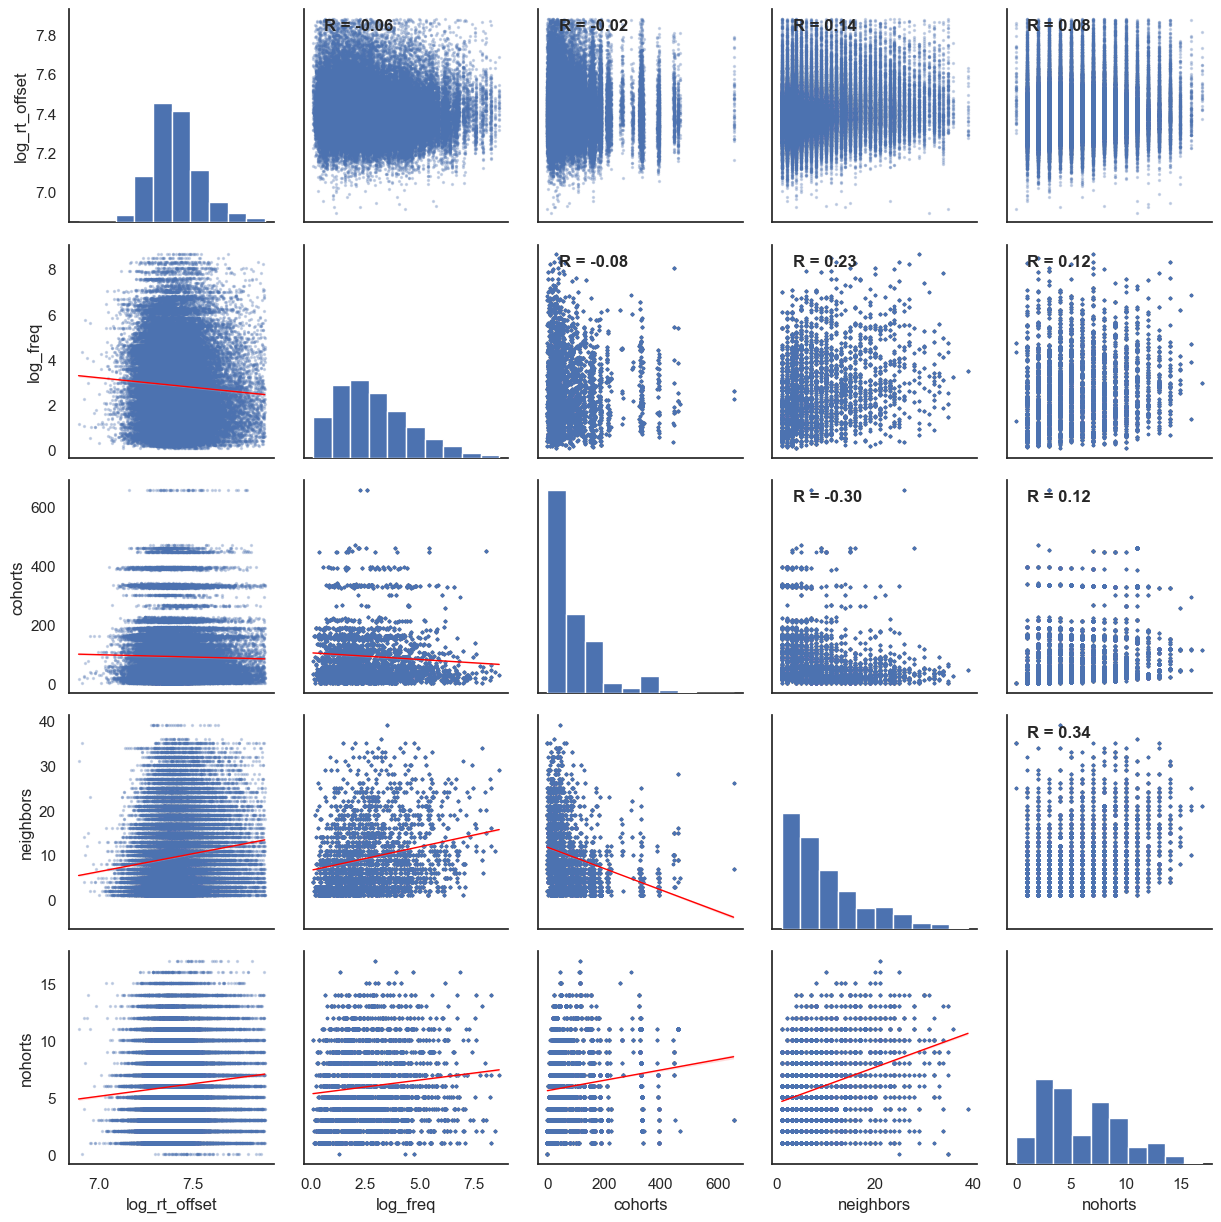

In [6]:
# make scatterplot matrix; this may take a minute or more to run

pointsize = 2   # determines how large the points are
alphaval = 0.25 # how transparent he points are
line_thickness = 1   # thickness of line of best fit

# Scatterplot matrix 
sns.set(style="white")
def corrfunc(x, y, **kws):
    r = np.corrcoef(x, y)[0,1]  # correlation
    ax = plt.gca()
    ax.annotate(f"R = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes, fontweight="bold")

pair_grid = sns.PairGrid(df, vars=['log_rt_offset', 'log_freq', 'cohorts', 'neighbors', 'nohorts'], height=2.5)
pair_grid = pair_grid.map_upper(plt.scatter, s=pointsize, alpha=alphaval)
pair_grid = pair_grid.map_upper(corrfunc)
pair_grid = pair_grid.map_lower(sns.regplot, scatter_kws={'s':pointsize, 'alpha':alphaval}, line_kws={'color':'red', 'linewidth':line_thickness})
pair_grid = pair_grid.map_diag(plt.hist)
plt.show()

That takes so long because there is a *lot* of data. We are ploting the values for every single response we have. We have many responses for every word, so there are a lot of redundant point in the predictor plots. Let's streamline by summarizing by word. We will get the mean reaction time (RT) for every word and then we will try the scatter plots again. 

In [7]:
# Summarizing over subjects to get the mean values for each item
df_items = df.drop(columns=['subject']).groupby('item').mean().reset_index()
df_items.head()

,item,log_rt_offset,frequency,log_freq,phon_length,duration,nohorts,cohorts,neighbors
0,ace,7.421250,14.73,2.755570,2.0,643.764,1.0,3.0,23.0
1,ache,7.385698,2.49,1.249902,2.0,635.986,1.0,5.0,24.0
2,act,7.336982,109.12,4.701571,3.0,630.091,2.0,52.0,9.0
3,add,7.446910,33.06,3.528124,2.0,603.560,2.0,47.0,22.0
4,age,7.479792,79.20,4.384524,2.0,547.914,1.0,3.0,18.0


In [8]:
df_items.describe()

,log_rt_offset,frequency,log_freq,phon_length,duration,nohorts,cohorts,neighbors
count,1976.000000,1976.000000,1976.000000,1976.000000,1976.000000,1976.000000,1976.000000,1976.000000
mean,7.416382,93.464190,2.781188,3.573887,723.591614,5.982287,89.672065,9.643725
std,0.067026,350.704907,1.667151,0.759484,126.643457,3.494544,94.212750,7.580360
min,7.184453,0.100000,0.095310,1.000000,344.626000,0.000000,0.000000,1.000000
25%,7.368959,3.465000,1.496267,3.000000,635.708500,3.000000,25.000000,4.000000
50%,7.418304,11.320000,2.511224,4.000000,720.306000,5.000000,54.000000,8.000000
75%,7.460874,45.480000,3.839021,4.000000,809.812750,8.000000,127.250000,14.000000
max,7.632844,5721.180000,8.652105,6.000000,1251.406000,17.000000,656.000000,39.000000


In [9]:
# let's save the original df in df_orig and just move df_items to df
df_orig = df
df = df_items
len(df)

1976

Rather than copying and pasting our scatterplot code from above, let's create a scatterplot function. 

# Define the function to create a scatterplot matrix with customizable options
def create_scatterplot_matrix(df, column_names, pointsize=2, alphaval=0.25, line_thickness=1):
    """
    Create a scatterplot matrix for a given DataFrame and list of column names.
    
    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - column_names (list): The list of column names to include in the scatterplot matrix.
    - pointsize (int, optional): The size of the points in the scatter plots. Default is 2.
    - alphaval (float, optional): The transparency of the points in the scatter plots. Default is 0.25.
    """
    sns.set(style="white")
    
    def corrfunc(x, y, **kws):
        r = np.corrcoef(x, y)[0,1]  # correlation
        ax = plt.gca()
        ax.annotate(f"R = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes, fontweight="bold")
        
    def blank(*args, **kwargs):
        pass

    pair_grid = sns.PairGrid(df, vars=column_names, height=2.5)
    #pair_grid = pair_grid.map_upper(plt.scatter, s=pointsize, alpha=alphaval)
    pair_grid = pair_grid.map_upper(sns.regplot, scatter_kws={'s':pointsize, 'alpha':alphaval}, line_kws={'color':'red', 'linewidth':line_thickness})
    pair_grid = pair_grid.map_upper(corrfunc)
    pair_grid = pair_grid.map_lower(plt.scatter, s=pointsize, alpha=alphaval)
    #pair_grid = pair_grid.map_lower(sns.regplot, scatter_kws={'s':pointsize, 'alpha':alphaval}, line_kws={'color':'red', 'linewidth':line_thickness})
    pair_grid = pair_grid.map_diag(plt.hist)
    plt.show()

# Test the function with the filtered DataFrame and specified columns
create_scatterplot_matrix(df, ['log_rt_offset', 'log_freq', 'cohorts', 'neighbors', 'nohorts'])


---

### Visualizing data in 3 dimensions

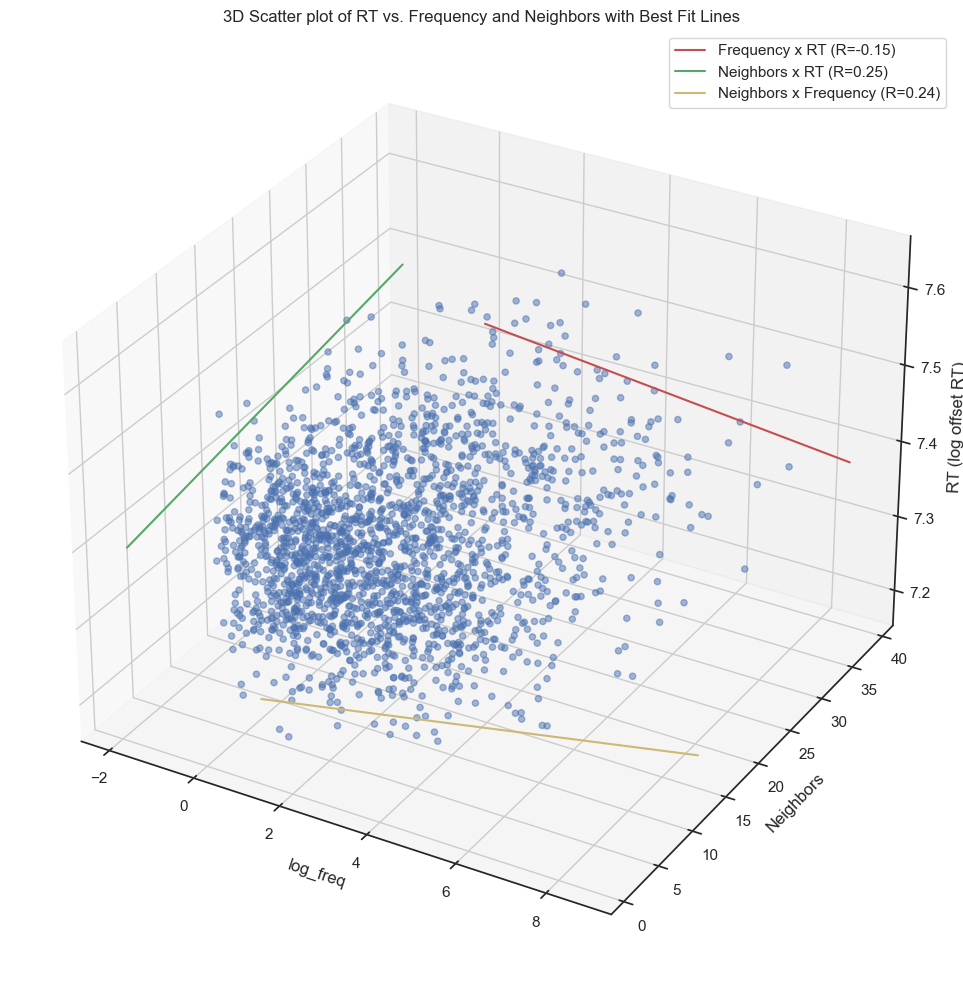

In [11]:
# Now let's explore 3 variables at a time using a 3d plot

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_line_endpoints(x, y):
    # Linear regression to get slope and intercept
    slope, intercept = np.polyfit(x, y, 1)
    # Calculate correlation coefficient (R value)
    r_value = np.corrcoef(x, y)[0, 1]
    
    # Using min and max values of x to get two end points for the line
    x_vals = np.array([x.min(), x.max()])
    y_vals = slope * x_vals + intercept
    
    return x_vals, y_vals, r_value

# Calculate endpoints for the best fit lines
x_rt_freq, y_rt_freq, r_rt_freq = compute_line_endpoints(df['log_freq'].values, df['log_rt_offset'].values)
x_rt_neigh, y_rt_neigh, r_rt_neigh = compute_line_endpoints(df['neighbors'].values, df['log_rt_offset'].values)
x_neigh_freq, y_neigh_freq, r_neigh_freq = compute_line_endpoints(df['log_freq'].values, df['neighbors'].values)

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df['log_freq'], df['neighbors'], df['log_rt_offset'], c='b', marker='o', alpha=0.5)

# Plot best fit lines

ax.plot(x_rt_freq, df['neighbors'].max() * np.ones_like(x_rt_freq), y_rt_freq, color='r', label=f"Frequency x RT (R={r_rt_freq:.2f})")
ax.plot((df['log_freq'].min()-2) * np.ones_like(x_rt_neigh), x_rt_neigh, y_rt_neigh, color='g', label=f"Neighbors x RT (R={r_rt_neigh:.2f})")
ax.plot(x_neigh_freq, y_neigh_freq, df['log_rt_offset'].min() * np.ones_like(x_neigh_freq), color='y', label=f"Neighbors x Frequency (R={r_neigh_freq:.2f})")

# Set labels, title and legend
ax.set_xlabel('log_freq')
ax.set_ylabel('Neighbors')
ax.set_zlabel('RT (log offset RT)')
ax.set_title('3D Scatter plot of RT vs. Frequency and Neighbors with Best Fit Lines')
ax.legend()
plt.tight_layout()
plt.show()


### Make it interactive

Just like we did with the pseudo data, let's make it interactive. But let's create another function that we can re-use. 

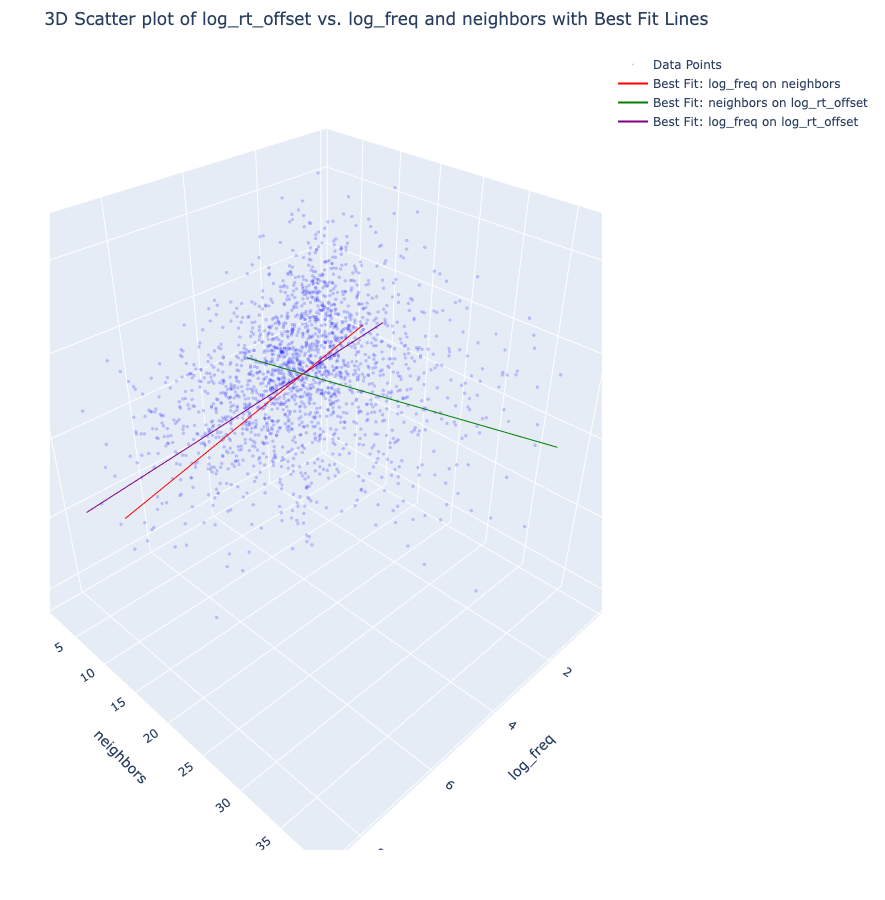

In [14]:
# Now make it interactive

import plotly.graph_objects as go
import numpy as np

def plot_interactive_3d(df, columns, pointsize=2, alphaval=0.2):
    """Create an interactive 3D scatter plot using Plotly"""
    
    if len(columns) != 3:
        return "Please specify exactly 3 columns."
    
    for col in columns:
        if df[col].dtype not in ['int64', 'float64']:
            return f"Column {col} is not numeric."
    
    def compute_line_endpoints(x, y):
        slope, intercept = np.polyfit(x, y, 1)
        x_vals = np.array([x.min(), x.max()])
        y_vals = slope * x_vals + intercept
        return x_vals, y_vals

    x1, x2, x3 = columns
    x_12, y_12 = compute_line_endpoints(df[x1].values, df[x2].values)
    x_13, y_13 = compute_line_endpoints(df[x1].values, df[x3].values)
    x_23, y_23 = compute_line_endpoints(df[x2].values, df[x3].values)

    scatter = go.Scatter3d(
        x=df[x1],
        y=df[x2],
        z=df[x3],
        mode='markers',
        marker=dict(size=pointsize, opacity=alphaval, color='blue'),
        name="Data Points"
    )
    
    line1 = go.Scatter3d(
        x=x_12,
        y=y_12,
        z=df[x3].mean() * np.ones_like(x_12),
        mode='lines',
        line=dict(color='red'),
        name=f"Best Fit: {x1} on {x2}"
    )
    
    line2 = go.Scatter3d(
        x=df[x1].mean() * np.ones_like(x_23),
        y=x_23,
        z=y_23,
        mode='lines',
        line=dict(color='green'),
        name=f"Best Fit: {x2} on {x3}"
    )
    
    line3 = go.Scatter3d(
        x=x_13,
        y=df[x2].mean() * np.ones_like(x_13),
        z=y_13,
        mode='lines',
        line=dict(color='purple'),
        name=f"Best Fit: {x1} on {x3}"
    )

    layout = go.Layout(
        width=900,
        height=900,
        margin=dict(l=50, r=50, b=50, t=50),
        scene=dict(
            xaxis_title=x1,
            yaxis_title=x2,
            zaxis_title=x3
        ),
        title=f"3D Scatter plot of {x3} vs. {x1} and {x2} with Best Fit Lines"
    )

    fig = go.Figure(data=[scatter, line1, line2, line3], layout=layout)
    fig.show()

# Example usage
plot_interactive_3d(df, ['log_freq', 'neighbors', 'log_rt_offset'])


### Multiple regression


In [15]:
# Now do multiple regressionimport pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def perform_multiple_regression(df, predictors, outcome):
    """
    Perform multiple linear regression.
    
    Parameters:
    - df: DataFrame containing the data
    - predictors: List of predictor variable names
    - outcome: Outcome variable name
    
    Returns:
    - Summary table of the regression model
    """
    # Prepare the data
    X = df[predictors]
    y = df[outcome]
    
    # Add a constant to the predictors (required for the statsmodels regression model)
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Get the summary table
    summary_table = model.summary()
    
    print("Regression Summary Table:")
    print(summary_table)
    
    # Check for multicollinearity using Variance Inflation Factor (VIF)
    print("\nVariance Inflation Factors:")
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print(vif_data)

# Perform multiple regression
perform_multiple_regression(df, ['log_freq', 'cohorts', 'neighbors'], 'log_rt_offset')


Regression Summary Table:
                            OLS Regression Results                            
Dep. Variable:          log_rt_offset   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     81.91
Date:                Wed, 18 Oct 2023   Prob (F-statistic):           6.10e-50
Time:                        20:34:53   Log-Likelihood:                 2653.2
No. Observations:                1976   AIC:                            -5298.
Df Residuals:                    1972   BIC:                            -5276.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4121     

In [16]:
# checks for collinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

def multiple_regression(df, predictors, outcome):
    """
    Perform multiple regression and print the summary table.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - predictors: List of predictor variable names (strings)
    - outcome: Name of the outcome variable (string)
    """
    # Extract predictors and outcome from DataFrame
    X = df[predictors]
    y = df[outcome]
    
    # Add constant term to predictors (required for statsmodels)
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X)
    result = model.fit()
    
    # Print summary statistics table
    print(result.summary())
    
    # Check for multicollinearity using the Variance Inflation Factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print("\nVariance Inflation Factors")
    print(vif_data)
    
    return result

def plot_coefficients(result, predictors):
    """
    Plot the beta coefficients with 95% confidence intervals.
    
    Parameters:
    - result: Fitted model from statsmodels
    - predictors: List of predictor variable names (strings)
    """
    # Extract coefficients and confidence intervals
    coefs = result.params[1:]
    conf_int = result.conf_int(alpha=0.05).iloc[1:]
    
    # Create plot
    y_size = len(predictors)  # Number of predictors determines the y-axis size
    plt.figure(figsize=(10, y_size))
    #plt.figure()
    plt.errorbar(coefs, predictors, xerr=[coefs - conf_int[0], conf_int[1] - coefs], fmt='o', capsize=5)
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel('Beta coefficients')
    plt.ylabel('Predictors')
    plt.title('Beta Coefficients with 95% Confidence Intervals')
    plt.xticks(rotation=45)
    plt.show()

# Perform multiple regression
predictors = ['log_freq', 'cohorts', 'neighbors', 'nohorts']
outcome = 'log_rt_offset'
result = multiple_regression(df, predictors, outcome)

                            OLS Regression Results                            
Dep. Variable:          log_rt_offset   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     63.94
Date:                Wed, 18 Oct 2023   Prob (F-statistic):           6.90e-51
Time:                        20:35:00   Log-Likelihood:                 2657.7
No. Observations:                1976   AIC:                            -5305.
Df Residuals:                    1971   BIC:                            -5277.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4079      0.004   1899.575      0.0

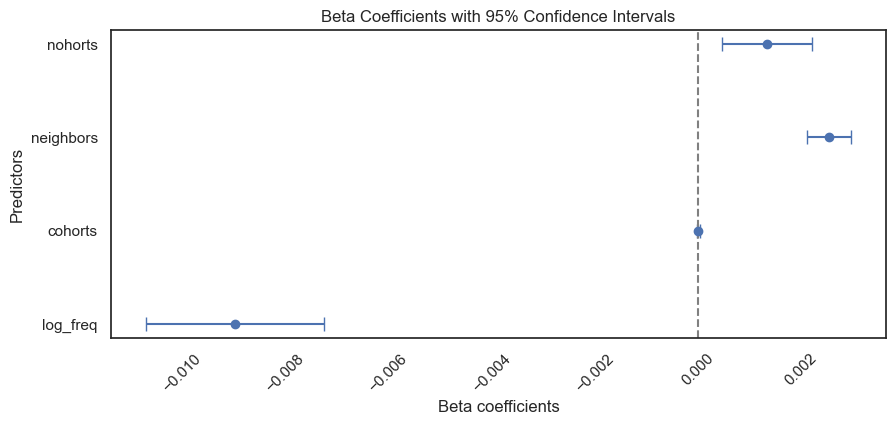

In [17]:
# Plot the coefficients
plot_coefficients(result, predictors)

                            OLS Regression Results                            
Dep. Variable:          log_rt_offset   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     63.94
Date:                Wed, 18 Oct 2023   Prob (F-statistic):           6.90e-51
Time:                        20:35:05   Log-Likelihood:                 2657.7
No. Observations:                1976   AIC:                            -5305.
Df Residuals:                    1971   BIC:                            -5277.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4164      0.001   5222.728      

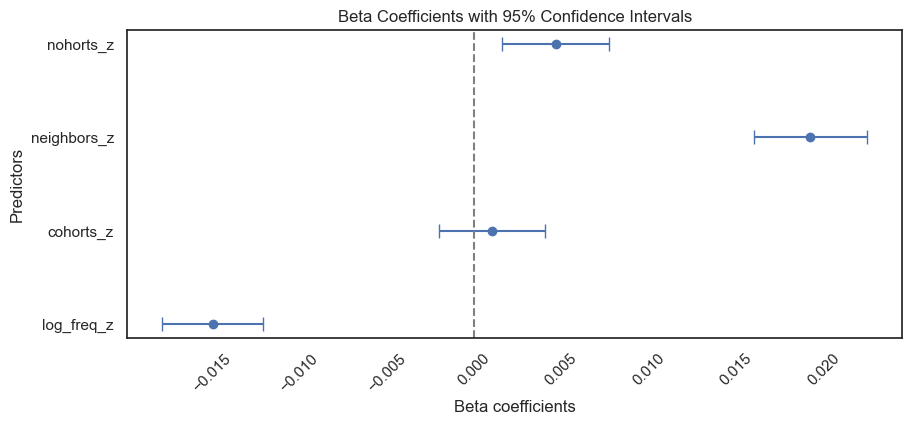

In [18]:
# let's standardizing and try again
from scipy.stats import zscore

# Z-standardizing the variables (rescaling as SD units)
df['cohorts_z'] = zscore(df['cohorts'])
df['nohorts_z'] = zscore(df['nohorts'])
df['neighbors_z'] = zscore(df['neighbors'])
df['log_freq_z'] = zscore(df['log_freq'])


# Perform multiple regression
predictors = ['log_freq_z', 'cohorts_z', 'neighbors_z', 'nohorts_z']
outcome = 'log_rt_offset'
result = multiple_regression(df, predictors, outcome)

# Plot the coefficients
plot_coefficients(result, predictors)




                            OLS Regression Results                            
Dep. Variable:          log_rt_offset   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     125.5
Date:                Wed, 18 Oct 2023   Prob (F-statistic):           5.14e-52
Time:                        20:35:09   Log-Likelihood:                 2655.4
No. Observations:                1976   AIC:                            -5305.
Df Residuals:                    1973   BIC:                            -5288.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.4164      0.001   52

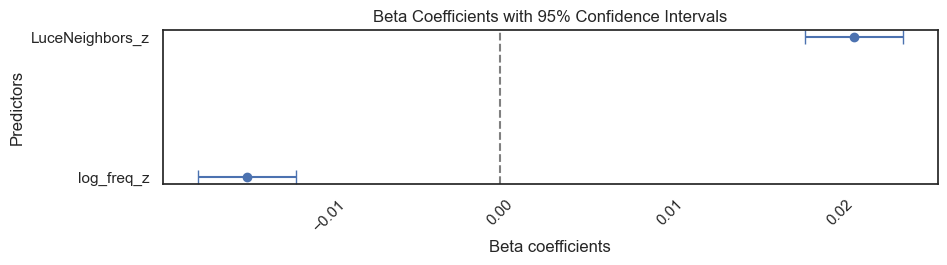

In [19]:
# Now let's try just an assessment of neighborhood

# Creating a new column that is the sum of "neighbors" and "nohorts"
df['LuceNeighbors'] = df['neighbors'] + df['nohorts']
df['LuceNeighbors_z'] = zscore(df['LuceNeighbors'])

# Now do regression and plot with just these variables


# Perform multiple regression
predictors = ['log_freq_z', 'LuceNeighbors_z']
outcome = 'log_rt_offset'
result = multiple_regression(df, predictors, outcome)

# Plot the coefficients
plot_coefficients(result, predictors)
